In [25]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy 
import os
from pathlib import Path

## Read raw images file
Using rawpy library to read the pixel values. [Documentation](https://letmaik.github.io/rawpy/api/rawpy.RawPy.html)

The camera should be 4000 * 6000 pixels but the raw image only has 3464*5202

[[0.00075758 0.00530303 0.01742424 ... 0.00378788 0.00681818 0.00909091]
 [0.01060606 0.0030303  0.         ... 0.         0.         0.00227273]
 [0.         0.         0.         ... 0.         0.00530303 0.00151515]
 ...
 [0.00530303 0.00757576 0.00681818 ... 0.         0.         0.00378788]
 [0.00606061 0.00606061 0.01060606 ... 0.         0.00681818 0.00075758]
 [0.00151515 0.00909091 0.         ... 0.00227273 0.00757576 0.        ]]
1.0


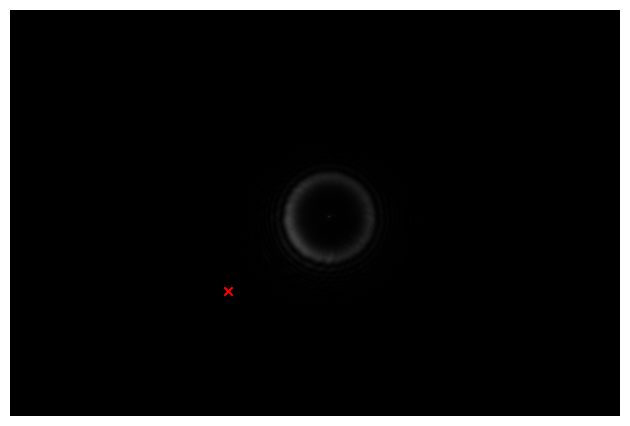

In [ ]:
# use rawpy library to read the pixel intensity values of the raw image

pardir = Path.cwd().parent
file = os.path.join(pardir, "experiment-images/camera-1/IMG_1807.CR2")

raw = rawpy.imread(file) 
black_level = raw.black_level_per_channel # black level offset 
raw_image = raw.raw_image_visible.astype(np.float32) # raw pixel intensity value
raw_image = raw_image - black_level[0] # apply black level correction
raw_image = np.clip(raw_image, 0, None) # avoid negavative values
raw_image_norm = raw_image / np.max(raw_image)

print(raw_image_norm)

rgb_image = raw.postprocess() # rgb image for visualisation

x_max, y_max = np.unravel_index(np.argmax(raw_image_norm), raw_image.shape)
print(np.max(raw_image_norm))

# min_index = np.unravel_index(np.argmin(raw_image), raw_image.shape)
# print(min_index)

# print(raw_image.shape)

# print(raw.raw_value(*min_index))

# Diplay image
plt.imshow(raw_image_norm, cmap='gray')
plt.scatter(x_max, y_max, color='red', marker = 'x')
plt.axis("off")
plt.tight_layout()
plt.show()



In [ ]:
# crop picture by taking bounds of non-black pixels
def crop_image(raw_image):
    raw_image_norm = raw_image / np.max(raw_image)
    non_black_pixels = np.argwhere(raw_image)